# Train a Denoising Diffusion Probabilistic Model from scratch

Welcome! In this exercise you will train a DDPM from scratch. After training the model will be able to generate images of cars.

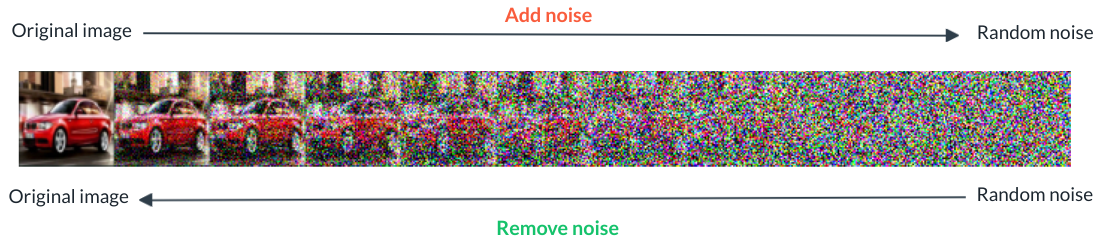

Let's get started!

## Initial setup

Here we import a few modules and we set up the notebook so it is fully reproducible:

In [7]:
# Make results fully reproducible:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

#os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = "python"

import random
import torch
import numpy as np

seed = 42

random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

# Import a few things we will need
import torch.nn.functional as F
import torch
from tqdm import tqdm
import multiprocessing

from torchvision import transforms 
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

## Dataset

Let's start by loading our training dataset. We are going to use the Stanford Cars dataset. It consists of 196 classes of cars with a total of 16,185 images. The images are 360×240. For this exercise we do not need any label, and we also do not need a test dataset, so we are going to load both the training and the test dataset and concatenate them. We are also going to transform the images to 64x64 by first resizing to 96x64 and then taking a center crop 64x64:

In [5]:
IMG_SIZE = 64
BATCH_SIZE = 100

def get_dataset(path):
    data_transform = transforms.Compose(
        [
            # Resize the short side to 64 pixels
            # (i.e., we go from 360x240 to 96x64)
            transforms.Resize(IMG_SIZE),
            # Take a random crop 64x64
            transforms.RandomCrop(IMG_SIZE),
            # We flip horizontally with probability 50%
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            # Scales data into [-1,1] 
            transforms.Normalize(0.5, 0.5)
        ]
    )
    
    train = torchvision.datasets.StanfordCars(root=path, download=True, 
                                         transform=data_transform)

    test = torchvision.datasets.StanfordCars(root=path, download=True, 
                                         transform=data_transform, split='test')
    
    return torch.utils.data.ConcatDataset([train, test])

data = get_dataset("/data/stanford_cars")
dataloader = DataLoader(
    data, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=False, 
    pin_memory=True, 
    num_workers=multiprocessing.cpu_count()
)

Let's look at a batch of images:

In [ ]:
# Get a batch
batch, _ = next(iter(dataloader))

# Display it
def display_sequence(imgs, dpi=75, nrow=8):
    
    fig, sub = plt.subplots(dpi=dpi)
    sub.imshow(
        np.transpose(
            make_grid(
                imgs, 
                padding=0,
                normalize=True,
                nrow=nrow,
            ).cpu(),
            (1,2,0)
        )
    )
    _ = sub.axis("off")
    
    return fig

_ = display_sequence(batch[:64], dpi=150)

## Noise scheduling and precomputation

In the forward process we need to add random noise according to a schedule. Here we use a linear schedule with 512 diffusion steps.

Let's define it:

In [2]:
# Define beta schedule
T = 512  # number of diffusion steps
betas = torch.linspace(start=0.0001, end=0.02, steps=T)  # linear schedule

As we have seen in the lesson, we need to use a re-parametrization of the forward process that allows us to generate noisy images at any step without having to sequentially go through all the previous steps:

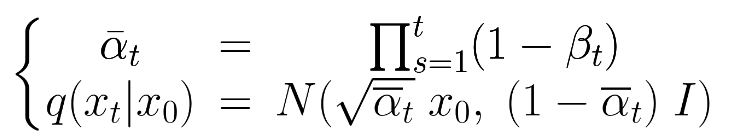

At inference time we will also need the quantities involved in these other formulas:

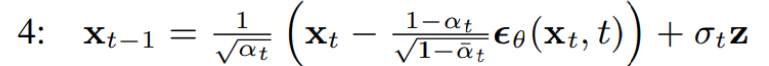
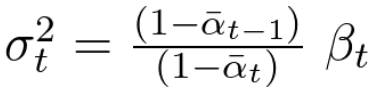

Here we define and precompute all these constants:

In [3]:
# Pre-calculate different terms for closed form
alphas = 1. - betas
# alpha bar
alphas_cumprod = torch.cumprod(alphas, axis=0)
# alpha bar at t-1
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
# sqrt of alpha bar
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)

# Inference:
# 1 / sqrt(alpha)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
# sqrt of one minus alpha bar
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
# sigma_t
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [4]:
@torch.no_grad()
def make_inference(input_noise, return_all=False):
    
    x = input_noise
    bs = x.shape[0]
    
    imgs = []
    
    for time_step in range(0,T)[::-1]:
        t = torch.full((bs,), time_step, device=device, dtype=torch.long)

        model_mean = sqrt_recip_alphas[t].view(bs, 1, 1, 1) * (
            x - betas[t].view(bs, 1, 1, 1) * model(x, t) / 
            sqrt_one_minus_alphas_cumprod[t].view(bs, 1, 1, 1)
        )
        
        noise = torch.randn_like(x) if time_step > 0 else 0
        
        x = model_mean + torch.sqrt(posterior_variance[t].view(bs, 1, 1, 1)) * noise
        
        imgs.append(torch.clamp(x, -1, 1))
    
    if return_all:
        return imgs
    else:
        return imgs[-1]
    
    return x

    
@torch.no_grad()
def sample_image(image, device='cpu', num_images=16, dpi=75, interleave=False):
    stepsize = int(T/num_images)
    
    imgs = []
    noises = []
    
    for i in range(0, T, stepsize):
        t = torch.full((1,), i, device=device, dtype=torch.long)

        # Forward diffusion process
        bs = image.shape[0]
        noise = torch.randn_like(image, device=image.device)
        img = (
            sqrt_alphas_cumprod[t].view(bs, 1, 1, 1) * image + 
            sqrt_one_minus_alphas_cumprod[t].view(bs, 1, 1, 1) * noise
        )

        imgs.append(torch.clamp(img, -1, 1).squeeze(dim=0))
        noises.append(torch.clamp(noise, -1, 1).squeeze(dim=0))
    
    if interleave:
        imgs = [item for pair in zip(imgs, noises) for item in pair]
        
    fig = display_sequence(imgs, dpi=dpi)
    
    return fig, imgs[-1]

In [5]:
# Simulate forward diffusion
batch = next(iter(dataloader))

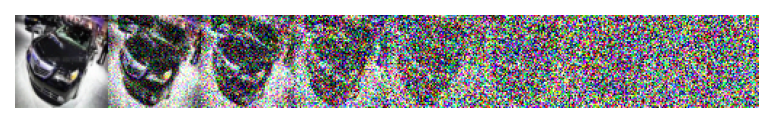

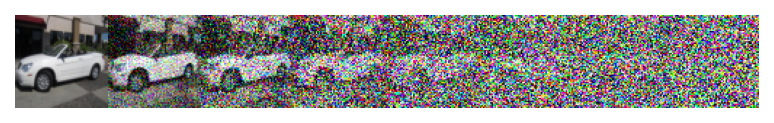

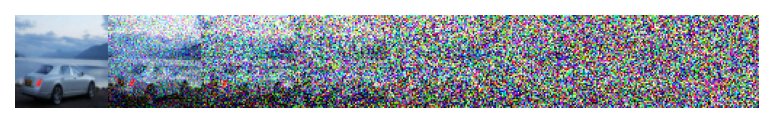

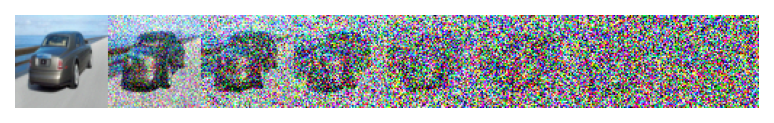

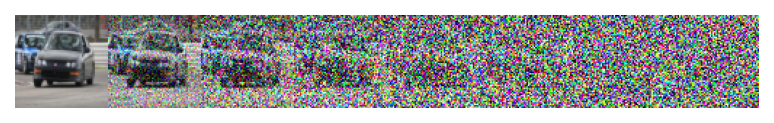

In [6]:
for i in range(5):
    image = batch[0][i]
    _ = sample_image(image.unsqueeze(dim=0), num_images=7, dpi=150, interleave=False)

In [7]:
from unet import UNet

In [8]:
model = UNet(ch_mults = (1, 2, 2, 2))
print("Num params: ", sum(p.numel() for p in model.parameters()))
# # Num params:  54563779
# print(model)

Num params:  54563779


In [9]:
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

device = "cuda" if torch.cuda.is_available() else "cpu"
# Move everything to GPU
model.to(device)

sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)
alphas_cumprod_prev = alphas_cumprod_prev.to(device)
sqrt_recip_alphas = sqrt_recip_alphas.to(device)
sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)
posterior_variance = posterior_variance.to(device)
betas = betas.to(device)

base_lr = 0.0001
optimizer = Adam(model.parameters(), lr=base_lr)

100%|██████████| 162/162 [04:06<00:00,  1.52s/it]


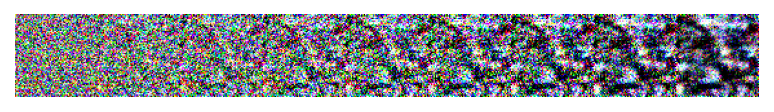

loss: 0.155, lr: 0.000050


100%|██████████| 162/162 [04:01<00:00,  1.49s/it]


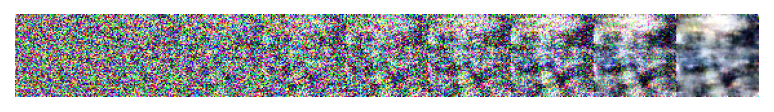

loss: 0.080, lr: 0.000100


100%|██████████| 162/162 [03:59<00:00,  1.48s/it]


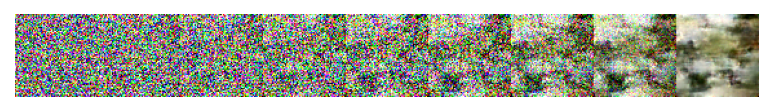

loss: 0.062, lr: 0.000075


100%|██████████| 162/162 [03:58<00:00,  1.47s/it]


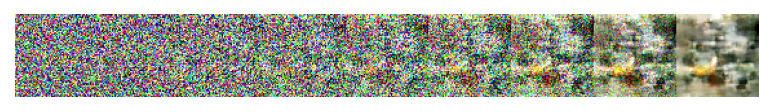

loss: 0.058, lr: 0.000025


100%|██████████| 162/162 [04:01<00:00,  1.49s/it]


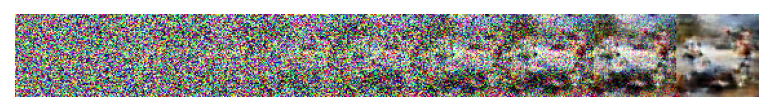

loss: 0.069, lr: 0.000000


In [10]:
epochs = 5 # Total number of epochs
T_max = epochs  # Number of epochs for Cosine Annealing
warmup_epochs = 2  # Number of warm-up epochs
scheduler = CosineAnnealingLR(
    optimizer, 
    T_max=T_max - warmup_epochs, 
    eta_min=1e-7
)

criterion = torch.nn.MSELoss()

fixed_noise = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)

# epochs_bar = tqdm(, total=epochs, desc='Epochs', position=0)

for epoch in range(epochs):
    
    if epoch < warmup_epochs:
        # Linear warm-up
        lr = base_lr * (epoch + 1) / warmup_epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    else:
        # Cosine Annealing after warm-up
        scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    
    last_loss = 0
    
    for batch, _ in tqdm(dataloader):
        
        batch = batch.to(device)
        bs = batch.shape[0]
        
        optimizer.zero_grad()

        t = torch.randint(0, T, (batch.shape[0],), device=device).long()
        
        # Generate targets for the UNet and apply them to the images
        noise = torch.randn_like(batch, device=device)
        x_noisy = (
            sqrt_alphas_cumprod[t].view(bs, 1, 1, 1) * batch + 
            sqrt_one_minus_alphas_cumprod[t].view(bs, 1, 1, 1) * noise
        )
                
        # The model predicts the noisy pixels.
        # Note that we pass in the
        # time step t
        noise_pred = model(x_noisy, t)
        loss = criterion(noise, noise_pred)
        
        loss.backward()
        optimizer.step()
        
        last_loss = loss.item()

    with torch.no_grad():
#         fig, _ = sample_image(fixed_noise, forward=False, device=device)
        imgs = make_inference(fixed_noise, return_all=True)
        fig = display_sequence([imgs[0].squeeze(dim=0)] + [x.squeeze(dim=0) for x in imgs[63::64]], nrow=9, dpi=150)
        plt.show(fig)
    os.makedirs("diffusion_output_long", exist_ok=True)
    fig.savefig(f"diffusion_output_long/frame_{epoch:05d}.png")
    #plt.close(fig)
    
    print(f"loss: {last_loss:.3f}, lr: {current_lr:.6f}")

In [11]:
input_noise = torch.randn((8, 3, IMG_SIZE, IMG_SIZE), device=device)
imgs = make_inference(input_noise)

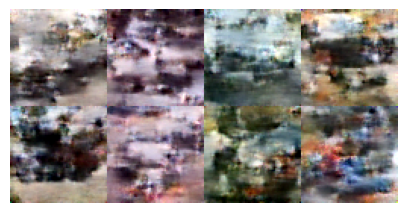

In [12]:
fig, sub = plt.subplots(figsize=(5, 5))
sub.imshow(
    np.transpose(
        make_grid(
            imgs, 
            padding=0,
            normalize=True,
            nrow=4,
        ).cpu(),
        (1,2,0)
    )
)
_ = sub.axis("off")

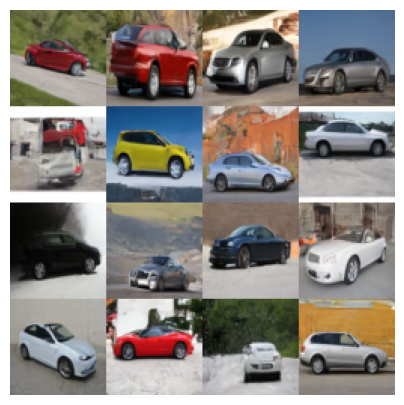